# <span style="color:#2834d4">활성화 함수 (activation function)</span>

In [1]:
import numpy as np
import matplotlib.pylab as plt

## 1. step function

### $h(x) = \begin{cases} 1 & (x>0) \\ 0 & (x\le0) \end{cases}$

In [2]:
def step_function(x):
    y = x > 0
    return y.astype(np.int64)

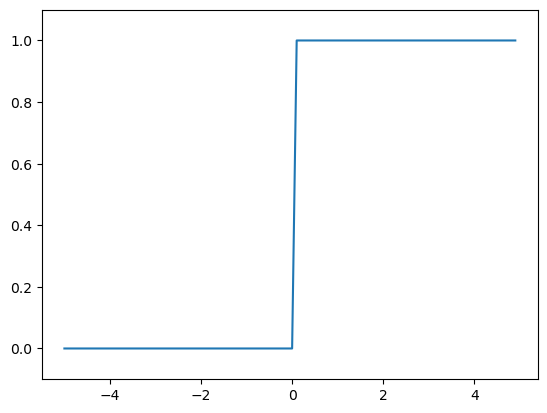

In [3]:
x = np.arange(-5.0, 5.0, 0.1)
y = step_function(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

## 2. sigmoid

## $h(x) = \frac{1}{1+e^{-x}}$

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

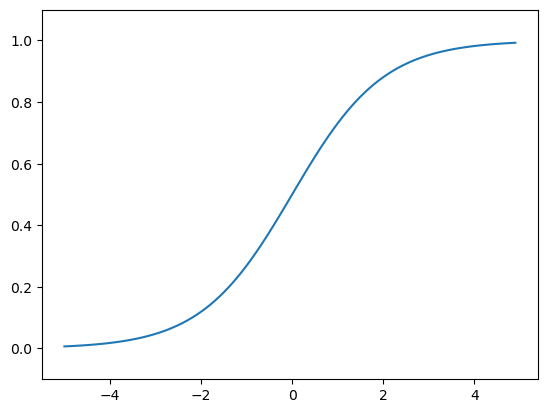

In [5]:
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1)
plt.show()

## 3. ReLU

### $h(x) = \begin{cases} x & (x>0) \\ 0 & (x\le0) \end{cases}$

In [6]:
def ReLU(x):
    return np.maximum(0, x)

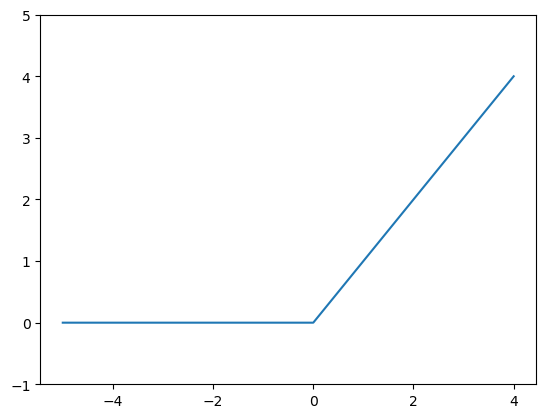

In [7]:
x = np.arange(-5, 5, 1)
y = ReLU(x)
plt.plot(x, y)
plt.ylim(-1, 5)
plt.show()

# <span style="color:#2834d4">3층 신경망 구현하기</span>

- input layer 2개, 1st hidden layer 3개, 2nd hidden layer 2개, output layer 2개 뉴런으로 구성 

In [11]:
def init_network():
    network ={}
    network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = np.array([0.1, 0.2, 0.3])
    network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = np.array([0.1, 0.2])
    network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = np.array([0.1, 0.2])
    
    return network

In [9]:
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = a3
    
    return y

In [12]:
network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

[0.31682708 0.69627909]


# <span style="color:#2834d4">출력층 설계하기</span>

## 1. softmax 함수 구현하기

## $ y_k = \frac{exp(x_k)}{\sum_{i=1}^n exp(x_i)}$

- 소프트맥스 적용해도 각 원소의 대소관계는 변하지 않음.
- 결과적으로 신경망으로 분류 시, 출력층의 소프트맥스 함수를 생략해도 됨.

In [14]:
def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x-c)  # overflow 방지
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    
    return y

In [15]:
x = np.array([0.3, 2.9, 4.0])
y = softmax(x)
print(y, np.sum(y))

[0.01821127 0.24519181 0.73659691] 1.0


# <span style="color:#2834d4">손글씨 숫자 인식</span>

## 1. 신경망의 추론 처리

In [16]:
import os, sys
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [17]:
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

In [18]:
import pickle

def init_network():
    with open("nets/ch3_sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
        
    return network

In [19]:
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

In [21]:
x, t = get_data()
network = init_network()

acc_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y)
    if p == t[i]:
        acc_cnt += 1

print("Accuracy: " + str(float(acc_cnt) / len(x)))

Accuracy: 0.9352


## 2. 배치 처리

In [22]:
x, t = get_data()
network = init_network()

batch_size = 100
acc_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)  # 행별로 최댓값을 가지는 원소 인덱스
    acc_cnt += np.sum(p==t[i:i+batch_size])  # bool 배열로 만들고 True 개수 return 
    
print("Accuracy: " + str(float(acc_cnt) / len(x)))

Accuracy: 0.9352


# <span style="color:#2834d4">정리</span>

- 신경망에서는 활성화함수로 시그모이드와 ReLU 같은 매끄럽게 변화하는 함수를 이용함
- 기계학습 문제는 크게 회귀와 분류로 나눌 수 있음
- 출력층의 활성화함수로는 회귀에서는 주로 항등함수, 분류에서는 주로 소프트맥스 함수를 이용함
- 분류에서는 출력층의 뉴런 수를 분류하려는 클래스의 수와 같게 설정함
- 입력 데이터를 묶은 것을 배치라 하며, 추론 처리를 배치 단위로 진행하면 결과를 훨씬 빠르게 얻을 수 있음